# Predictions for SpeciesTest samples with SpeciesTrain model

Training starting from best saved model

Mm->HsPre

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K


Tensorflow version:

In [13]:
tf.__version__

'2.9.0'

Python Version:

In [14]:
import sys
print(sys.version)

3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


In [15]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)


#INIT 
data_dir=''
fname=''
models_dir=''

Not running on CoLab
Num GPUs Available: 1
Found GPU at: /device:GPU:0
Wed May 24 13:58:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8    N/A /  N/A |   1863MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                 

In [16]:
########################################
# PARAMS
########################################

#------------------ Mm -> Hs -------------------------------
species_train_model_name = 'TFM_LSTMBidiAttention_MM_ALLMM'
cross_test_name = 'Predict_Mm_to_HsPre'
fname = 'hg38_RS_DL_PRE_Pad_W50_1000GENES_BALANCED_1_1_CODED2CH.csv'
dirname = 'ALL_HG38_PRE'
#-------------------------------------------------



padding=True
ptrain = 0.1
random_seed=2022

numchannels=2

if numchannels==3:
   categories_size=60
else:
   categories_size=20

if padding==True:
    categories_size=categories_size+1

if GOOGLE_COLAB==False:
    data_dir = '../../data/datasets/'+dirname+'/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    #set the path to find RNAEd module
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/'+dirname+'/W50'
    models_dir= '/content/drive/MyDrive/MODELS'
#########################################

SPECIES TRAIN MODEL:

In [17]:
saved_model =  species_train_model_name+'.h5'
savedmodelfile = os.path.join(models_dir, saved_model)
print("SPECIES TRAIN MODEL FILE: {}".format(savedmodelfile))

SPECIES TRAIN MODEL FILE: ./SAVED_MODELS\TFM_LSTMBidiAttention_MM_ALLMM.h5


SPECIES TEST DATASET:

In [18]:
datafile = os.path.join(data_dir, fname)
print("SPECIES TEST DATASET: {}".format(datafile))
data = pd.read_csv(datafile,sep=";")
print("shape data={}".format(data.shape))

SPECIES TEST DATASET: ../../data/datasets/ALL_HG38_PRE/W50\hg38_RS_DL_PRE_Pad_W50_1000GENES_BALANCED_1_1_CODED2CH.csv
shape data=(115464, 104)


In [19]:
print(data.head)

<bound method NDFrame.head of                                   GENE    POS  EDITING  P1  P2  P3  P4  P5  \
0                     PARP1_PARP1_chr1  15864        0  16   1  16  16  16   
1                     NTNG2_NTNG2_chr9  12888        0   8   8   3  13   3   
2       LOC107985892_LOC107985892_chr2  20740        0   2   7   2  17  17   
3                    COPS2_COPS2_chr15  24508        0   2  17   2   7  17   
4                      PLD3_PLD3_chr19   8066        0   6   6  11  16   6   
...                                ...    ...      ...  ..  ..  ..  ..  ..   
115459       LINC00507_LINC00507_chr12  13855        1  16  19   6  16  16   
115460             ZNF207_ZNF207_chr17   7804        1  11  16   6   6   6   
115461  LOC101927296_LOC101927296_chr3  33593        1   1   6   1   1  11   
115462             NCAPD2_NCAPD2_chr12  37543        1   3   8   6   6   1   
115463               LMNB2_LMNB2_chr19  22682        1  16   1   1   3   3   

        P6  P7  ...  P92  P93  P9

In [20]:
# Train and Validation+Test
data_train, data_val_test, data_y_train, data_y_val_test = train_test_split(data, data['EDITING'], test_size=1-ptrain, random_state=random_seed)
#Validation and test: 0.1/0.9
data_val, data_test, data_y_val, data_y_test = train_test_split(data_val_test, data_y_val_test, test_size=0.9, random_state=random_seed)

print("dismissing... data_train:{} data_y_train:{}".format(data_train.shape,data_y_train.shape))
print("dismissing... data_val: {} data_y_val: {}".format(data_val.shape,data_y_val.shape))

print("Selecting data for testing... data_test: {} data_y_test: {}".format(data_test.shape,data_y_test.shape))
print("TEST LABELS:")
print(data_y_test.value_counts())

dismissing... data_train:(11546, 104) data_y_train:(11546,)
dismissing... data_val: (10391, 104) data_y_val: (10391,)
Selecting data for testing... data_test: (93527, 104) data_y_test: (93527,)
TEST LABELS:
0    46813
1    46714
Name: EDITING, dtype: int64


Recover saved model

In [21]:
#Load the trained model from disk
import os.path

if os.path.exists(savedmodelfile):
    model = tf.keras.models.load_model(savedmodelfile)
    # Show the model architecture
    model.summary()
else:
    print("ERROR model {} nor found ".format(savedmodelfile))           



Model: "TFM_LSTMBidiAttention_MM_ALLMM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 101, 1)       513         ['dropout[0][0]']                
                                                                     

In [22]:
#PREDICTIONS
#DataGenerator converts on the fly from raw data to one-hot
if GOOGLE_COLAB==False:
    from rnaed import DataGenerator
else:
    from RNAEd import DataGenerator


#DataGenerator converts on the fly from raw data to one-hot
num_nucleosides = data_test.iloc[:,3:].shape[1]
num_tokens = categories_size

pred_generator       = DataGenerator( data_test.iloc[:,3:], data_y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )
model_prediction = model.predict(pred_generator,verbose=1)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

93527/93527 [==============================] - 1317s 14ms/step


In [23]:
print(data_test.shape)
print(data_y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(93527, 104)
(93527,)
(93527, 1)
(93527, 1)


In [24]:
#METRICS QUALITY CLASSIFICATION
print("MODEL "+cross_test_name+"\n---------------------------------")
kappa = cohen_kappa_score(data_y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(data_y_test, model_prediction_binary))

MODEL Predict_Mm_to_HsPre
---------------------------------
Kappa: 0.427
              precision    recall  f1-score   support

           0       0.71      0.74      0.72     46813
           1       0.72      0.69      0.71     46714

    accuracy                           0.71     93527
   macro avg       0.71      0.71      0.71     93527
weighted avg       0.71      0.71      0.71     93527



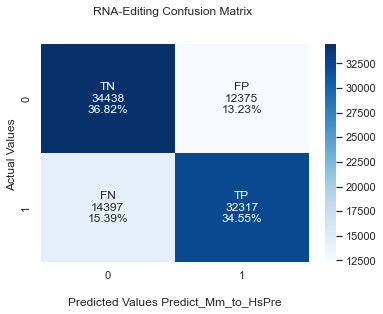

In [25]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
# Tutorial: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
plt.figure()

cm = confusion_matrix(data_y_test,model_prediction_binary)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('RNA-Editing Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values '+ cross_test_name)
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])
plt.show()

AUC: 0.80


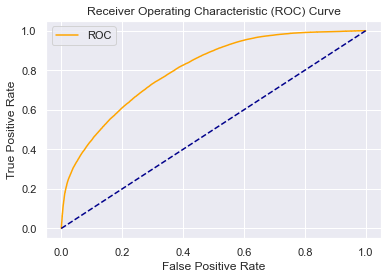

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(data_y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(data_y_test, model_prediction)
plot_roc_curve(fpr, tpr)

RESULTS INSIGHT

In [27]:
results_data = data_test
if 'RESULT_TYPE' not in results_data.columns:
    #insert column at position 3
    results_data.insert(3,"RESULT_TYPE", None)
    results_data.insert(4,"PROB_PRED",model_prediction)
else:
    print("RESULT_TYPE already exists in the dataframe")

results_data.head()

,GENE,POS,EDITING,RESULT_TYPE,PROB_PRED,P1,P2,P3,P4,P5,...,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101
70384,PXDC1_PXDC1_chr6,20298,0,None,0.606543,13,11,13,11,13,...,6,3,3,3,8,3,11,6,16,18
78700,GIGYF2_GIGYF2_chr2,12810,1,None,0.372666,11,16,6,6,6,...,1,16,11,18,11,12,17,7,2,12
49400,ZNF587B_ZNF587B_chr19,8150,1,None,0.456314,1,3,6,1,11,...,1,11,16,18,1,6,6,0,6,6
46511,TENT2_TENT2_chr5,14156,1,None,0.538001,16,16,6,1,18,...,7,17,17,17,17,17,2,2,17,17
79587,ZNF616_ZNF616_chr19,14158,1,None,0.974124,6,11,1,11,6,...,11,11,1,11,16,1,6,6,16,6


In [28]:
column_index=results_data.columns.get_loc('RESULT_TYPE')
i=0
for result in model_prediction_binary:
    #print("Comparing result={} with data_y_test={}".format(result[0],data_y_test.iloc[i]))
    if   result[0]==0 and data_y_test.iloc[i]==0:
       typeRes ="TN"
    elif result[0]==0 and data_y_test.iloc[i]==1:
       typeRes="FN"
    elif result[0]==1 and data_y_test.iloc[i]==0:
       typeRes="FP"
    elif result[0]==1 and data_y_test.iloc[i]==1:
       typeRes="TP"
    results_data.iloc[i, column_index]=typeRes
    i+=1
    
results_data.head()

,GENE,POS,EDITING,RESULT_TYPE,PROB_PRED,P1,P2,P3,P4,P5,...,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101
70384,PXDC1_PXDC1_chr6,20298,0,FP,0.606543,13,11,13,11,13,...,6,3,3,3,8,3,11,6,16,18
78700,GIGYF2_GIGYF2_chr2,12810,1,FN,0.372666,11,16,6,6,6,...,1,16,11,18,11,12,17,7,2,12
49400,ZNF587B_ZNF587B_chr19,8150,1,FN,0.456314,1,3,6,1,11,...,1,11,16,18,1,6,6,0,6,6
46511,TENT2_TENT2_chr5,14156,1,TP,0.538001,16,16,6,1,18,...,7,17,17,17,17,17,2,2,17,17
79587,ZNF616_ZNF616_chr19,14158,1,TP,0.974124,6,11,1,11,6,...,11,11,1,11,16,1,6,6,16,6


In [29]:
#Save the results into a file
if GOOGLE_COLAB==False:
    report_dir="./report"
else:
    report_dir="/content/drive/MyDrive/REPORT"

results_csv_file  =cross_test_name + "_Results.csv"
results_excel_file=cross_test_name + "_Results.xlsx"
results_data.to_csv(os.path.join(report_dir,results_csv_file))
results_data.to_excel(os.path.join(report_dir,results_excel_file))

Now, we are going to find the record with highest probability and category TP (True Positive) as a good model of TP data,
and alternatively, the best representative of TN, using the lowest value

In [30]:
subset_TP=results_data.loc[results_data['RESULT_TYPE'] == 'TP']
prototype_of_TP_id=subset_TP['PROB_PRED'].idxmax()
print("rowid best TP = {}".format(prototype_of_TP_id))
print(results_data.loc[prototype_of_TP_id,])

rowid best TP = 85721
GENE           BNIP3L_BNIP3L_chr8
POS                          2393
EDITING                         1
RESULT_TYPE                    TP
PROB_PRED                0.990305
                      ...        
P97                            16
P98                            16
P99                            11
P100                            3
P101                            6
Name: 85721, Length: 106, dtype: object


In [31]:
subset_TN=results_data.loc[results_data['RESULT_TYPE'] == 'TN']
prototype_of_TN_id=subset_TN['PROB_PRED'].idxmin()
print("rowid best TN = {}".format(prototype_of_TN_id))
print(results_data.loc[prototype_of_TN_id,])

rowid best TN = 35972
GENE           POLR2J2_POLR2J2_chr7
POS                           25366
EDITING                           0
RESULT_TYPE                      TN
PROB_PRED                  0.017578
                       ...         
P97                              17
P98                              17
P99                               2
P100                             17
P101                              7
Name: 35972, Length: 106, dtype: object
